# Flatiron Project 3: Building Multi-Classification Models
### Business Goal: Classify rock songs on Spotify into musical eras, based on their auditory attributes
### By David Shin and Khyatee Desai<br>Nov. 13, 2020

In [49]:
from zipfile import ZipFile 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle 
from itertools import combinations
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
import xgboost as xgb
set_config(print_changed_only=False, display=None)
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning
Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [65]:
# extract relevant csv files from zipped folder
with ZipFile("data/datasets.zip") as z:
    df = pd.read_csv(z.open(z.infolist()[0].filename))
#     df_artist = pd.read_csv(z.open(z.infolist()[1].filename))
#     df_avg_genre = pd.read_csv(z.open(z.infolist()[2].filename))
#     df_yr = pd.read_csv(z.open(z.infolist()[3].filename))
    df_genre = pd.read_csv(z.open(z.infolist()[4].filename))

In [66]:
df.sample(3) # main dataframe

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
87073,0.0469,['Andy Grammer'],0.674,189933,0.7780,0,4Jz4bjXeiF2SXVj9P4YfY5,0.000000,0,0.1450,-5.367,1,Keep Your Head Up,70,2011-06-14,0.0376,90.010,0.8160,2011
146808,0.8990,['The Moonglows'],0.352,222840,0.1020,0,0PebhGIynG9vDbrV66UiKV,0.000006,3,0.0834,-16.865,1,Ten Commandments Of Love,17,1959-05-13,0.0417,174.400,0.2450,1959
41141,0.9610,"['Giuseppe Verdi', 'Vittorio Gui', 'Coro di Ro...",0.248,134667,0.0784,0,2ZN3hB1l3SRvdqRYE7jp8X,0.154000,7,0.0985,-31.488,1,"Verdi : Aida : Act 3 ""O tu che sei d'Osiride"" ...",0,1951,0.0429,129.337,0.0976,1951


In [67]:
df_genre.sample(3) # will be used to join genre column with main df

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
7134,Elvin Jones,0.6212,0.4816,267448.0,0.3468,2.202160e-03,0.16376,-17.0766,0.04782,87.3596,0.5392,23.2,10,1,5,"['avant-garde jazz', 'bebop', 'contemporary po..."
19625,Ram Herrera,0.3905,0.6845,237500.0,0.4075,8.350000e-07,0.35250,-11.8100,0.03265,92.5955,0.8050,41.5,9,1,4,['tejano']
20408,Robin Leggate,0.9890,0.2180,156400.0,0.1100,9.020000e-02,0.11400,-24.4770,0.05020,77.7950,0.0371,22.0,7,1,2,['classical tenor']


In [4]:
#Check for NA Values
df.isna().sum().any()

False

In [5]:
#Review datatypes in table
df.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [6]:
# drop irrelevant features
df_genre = df_genre[['artists', 'genres']]
df_genre.sample(3)

,artists,genres
17028,Musica Antiqua Köln,"['baroque ensemble', 'classical performance', ..."
10708,Jack Jones,"['adult standards', 'brill building pop', 'eas..."
5600,Dave Pell Octet,[]


### Join together main and genres dataframes

In [7]:
# unpack lists in the Artists column, retain the first artist of the list
df['artists'] = df['artists'].str.slice(1,-1).str.split(',')
df['artists'] = df['artists'].map(lambda x: x[0])
df['artists'] = df['artists'].str.slice(1,-1)

In [8]:
merged =df.merge(df_genre, on='artists')

# Keep rows within 'rock' genre
rock_df =merged[merged['genres'].str.contains('rock')]
rock_df.sample(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,genres
135815,0.0214,Os Paralamas Do Sucesso,0.459,191216,0.878,0,5XKUTawRWuTb8edaGn38gB,0.000006,9,0.127,-8.061,1,Vital E Sua Moto,55,1983-01-01,0.0641,152.372,0.913,1983,"['brazilian rock', 'latin alternative', 'latin..."
62117,0.3210,Wings,0.219,228507,0.939,0,5wrbTJZIoQIR3LsoMUGmil,0.144000,4,0.993,-9.275,1,"Hi, Hi, Hi - Live / Remastered",28,1976-12-10,0.2260,140.832,0.162,1976,"['album rock', 'art rock', 'beatlesque', 'clas..."
64119,0.0821,Sweet,0.644,246573,0.799,0,3Pu3IChaAoa5EjgUBv5F6x,0.001540,4,0.055,-10.856,0,Ballroom Blitz,62,1974-11,0.0598,108.381,0.889,1974,"['album rock', 'blues rock', 'classic rock', '..."


### Target Variable Binning

In [9]:
# Create target variable based on year ranges
conditions = [
    (rock_df['year'] >=1950) & (rock_df['year'] <1970),
    (rock_df['year'] >=1970) & (rock_df['year'] <1990),
    (rock_df['year'] >=1990) & (rock_df['year'] <2010)]
choices = [
    '50s/60s', '70s/80s', '90s/2000s']
rock_df['era'] = np.select(conditions, choices, default='NA')

In [10]:
# drop rows with dates outside the relevant ranges
rock_df = rock_df[rock_df['era'] !='NA']

# drop irrelevant features
rock_df.drop(['artists', 'id', 'name', 'release_date', 'genres', 'year'], axis=1, inplace=True)

In [11]:
y = rock_df['era']
X = rock_df.drop(['era'], axis=1)

### Impute Outliers

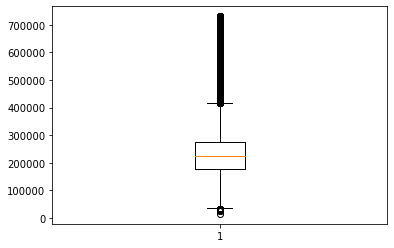

In [12]:
# Bring outliers down/up to 5 standard deviations from the mean
for feat in X:
    abv_5_std = X[feat].mean()+ 5*X[feat].std()
    below_5_std = X[feat].mean()- 5*X[feat].std()
    conditions = [X[feat]>abv_5_std, X[feat]<below_5_std]
    choices = [abv_5_std, below_5_std]
    X[feat] = np.select(conditions, choices, X[feat])

plt.boxplot(X.duration_ms);

# Exploratory Data Analysis

### Feature Scaling

In [13]:
loud = rock_df['loudness']
tempo = rock_df['tempo']
speech = rock_df['speechiness']
val = rock_df['valence']
pop = rock_df['popularity']
rock_df['scaled_loudness'] = (loud - min(loud)) / (max(loud) - min(loud))
rock_df['scaled_tempo'] = (tempo - min(tempo)) / (max(tempo) - min(tempo))
rock_df['scaled_speech'] = (speech - min(speech)) / (max(speech) - min(speech))
rock_df['scaled_val'] = (val - min(val)) / (max(val) - min(val))
rock_df['scaled_pop'] = (pop - min(pop)) / (max(pop) - min(pop))

In [14]:
#row, column count
rock_df.shape

(50496, 20)

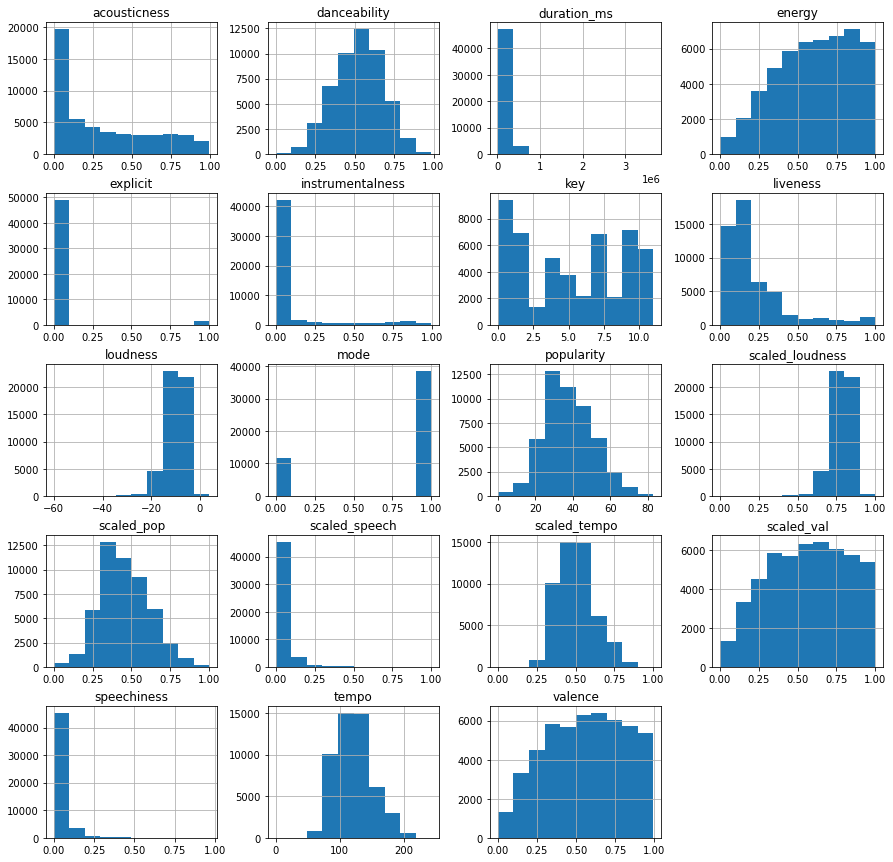

In [15]:
#Plot Histogram of all values
rock_df.hist(figsize=(15,15));

### Correlation Plot

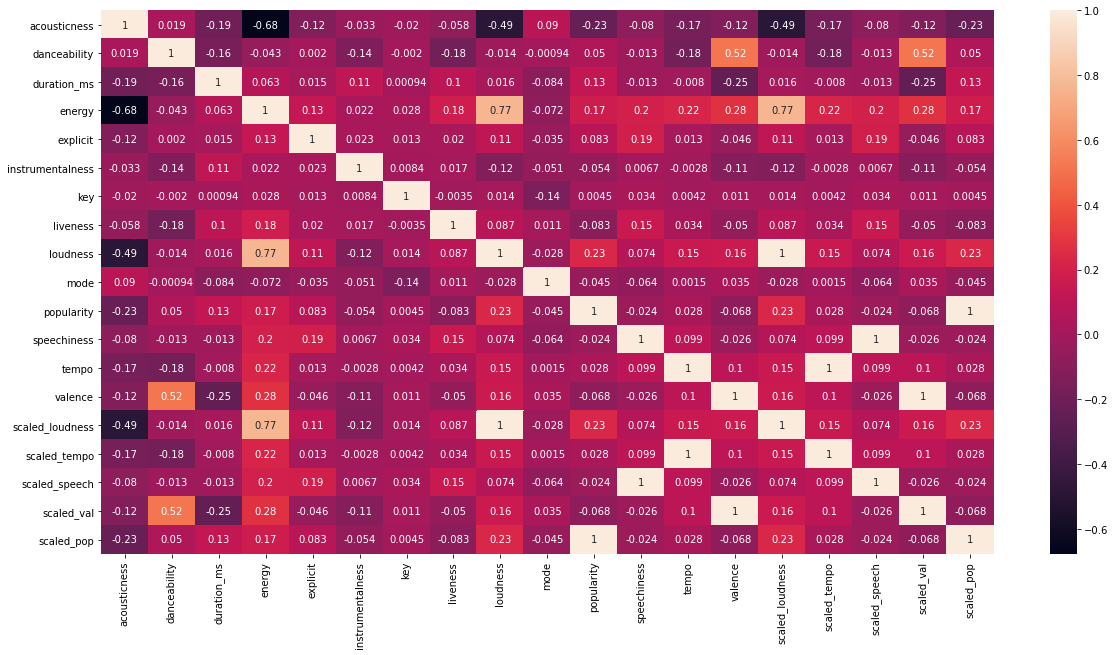

In [16]:
# Inspect correlations between features
plt.figure(figsize=(20, 10))
sns.heatmap(rock_df.corr(),annot=True);

In [17]:
rock_df.groupby('era').mean()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,scaled_loudness,scaled_tempo,scaled_speech,scaled_val,scaled_pop
era,,,,,,,,,,,,,,,,,,,
50s/60s,0.524810,0.514813,186224.483184,0.493339,0.000418,0.074221,5.156257,0.206261,-11.105119,0.814915,27.555881,0.053066,118.552521,0.614965,0.767051,0.487125,0.055048,0.619300,0.331999
70s/80s,0.284077,0.525268,250006.081207,0.603942,0.011263,0.095978,5.156309,0.225283,-10.807004,0.757561,36.307971,0.055994,122.717807,0.571292,0.771727,0.504240,0.058085,0.575320,0.437445
90s/2000s,0.210889,0.526563,248788.713844,0.673714,0.068641,0.082682,5.257952,0.204978,-8.088355,0.748744,46.398390,0.058737,123.179978,0.507391,0.814377,0.506139,0.060930,0.510968,0.559017


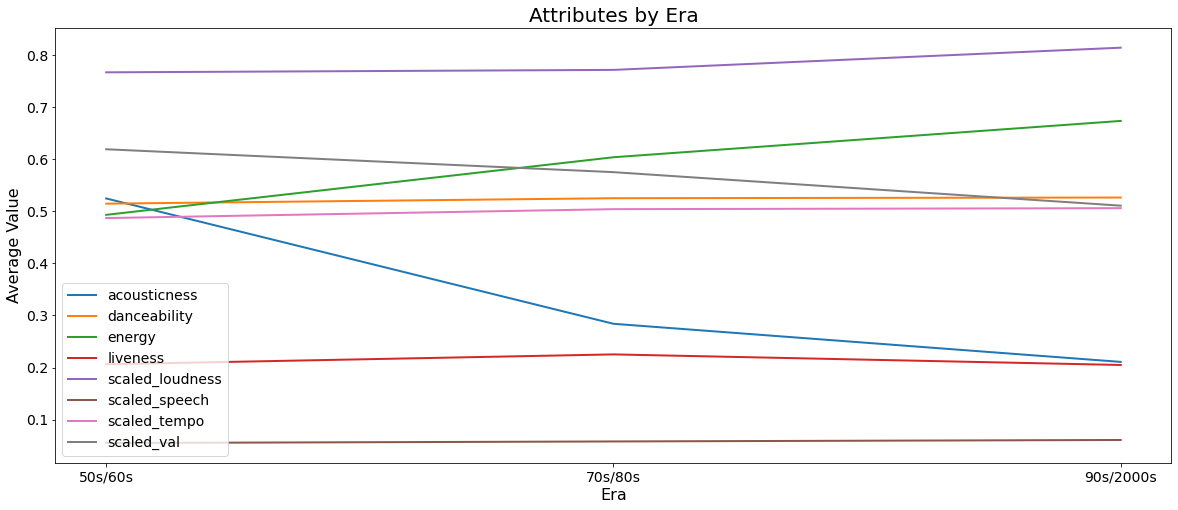

In [18]:
plt.figure(figsize=(20, 8))
attributes = ["acousticness","danceability","energy","liveness","scaled_loudness","scaled_speech","scaled_tempo","scaled_val"]
for attribute in attributes:
    x = rock_df.groupby("era")[attribute].mean()
    ax= sns.lineplot(x=x.index,y=x,label=attribute,linewidth = 2, seed=4)

ax.set_title('Attributes by Era', fontsize=20);
ax.set_ylabel('Average Value', fontsize=16);
ax.set_xlabel('Era', fontsize=16);
ax.legend(prop=dict(size=14));
ax.set_xticklabels(fontsize=14, labels=['50s/60s', '70s/80s', '90s/2000s']);
ax.set_yticklabels(fontsize=14, labels=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]);


Above chart shows the major attributes shown in our table by era. Upon initial inspection, some major changes throughout the era's are acousticness, energy, and valence. 

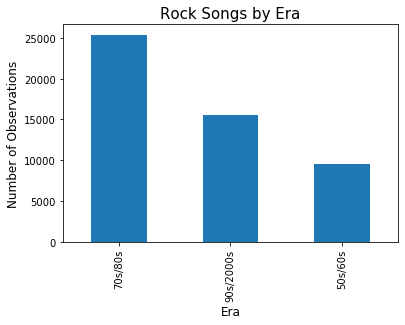

In [77]:
chart =rock_df['era'].value_counts().plot(kind='bar');
chart.set_title('Rock Songs by Era', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Era', fontsize=12);

The chart above shows that most of our target values lie in the 70's/80's era

## Plotting Specific Features
Based on the popularity distribution, we decided to remove popularity from the dataframe given that popularity is not a sound-based song attribute, and might be skewed due to spotify's younger demographic

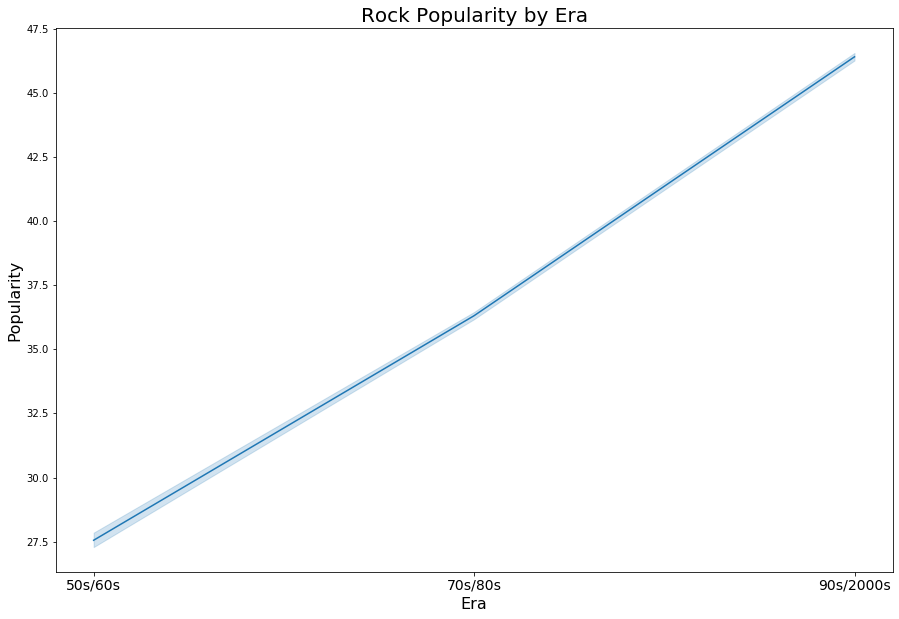

In [80]:
dffig,axes=plt.subplots(1,1,figsize=(15,10))
sns.lineplot(x='era',y='popularity',data=rock_df, palette="Blues");
axes.set_xlabel('Era', fontsize=16);
axes.set_ylabel('Popularity', fontsize=16);
axes.set_title('Rock Popularity by Era', fontsize=20);
axes.set_xticklabels(fontsize=14, labels=['50s/60s', '70s/80s', '90s/2000s']);

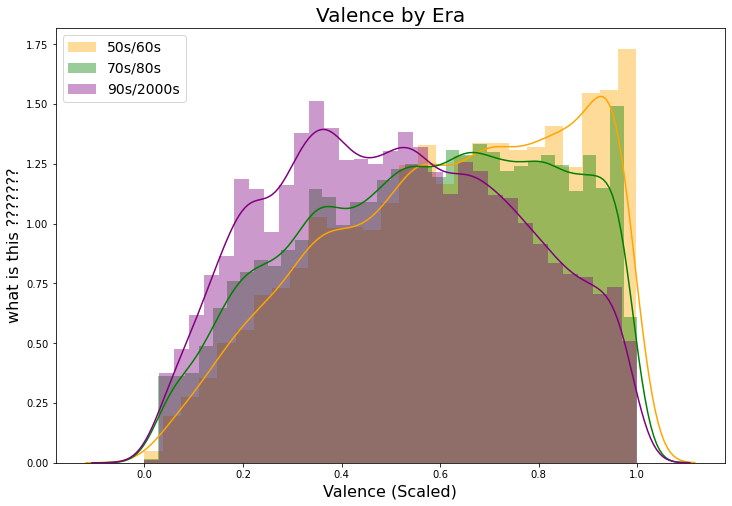

In [21]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df['scaled_val'][rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Valence by Era', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('Valence (Scaled)', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a lower valence is more common for recent rock songs, whereas a higher valence is more common in the 50's-80's eras. 

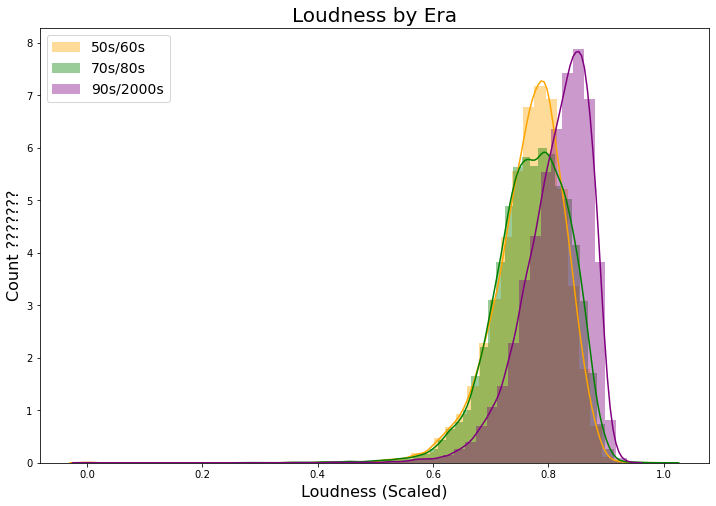

In [22]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df['scaled_loudness'][rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Loudness by Era', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('Loudness (Scaled)', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a higher loudness is more common for recent rock songs, whereas a lower loudness is more common in the 50's-80's eras. 

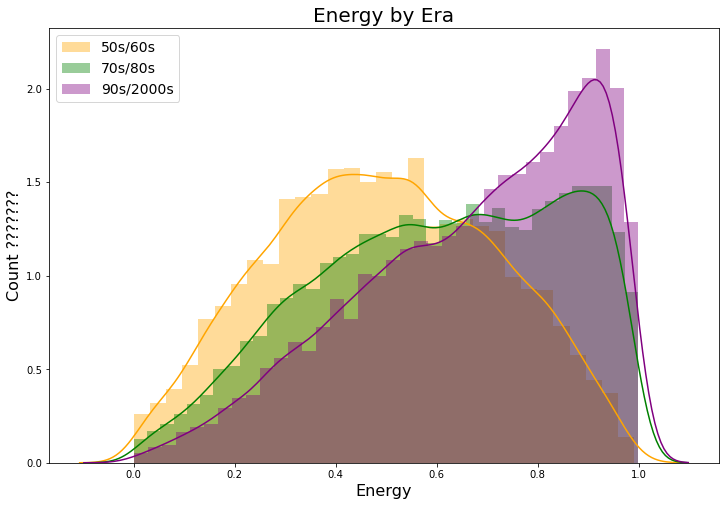

In [23]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df.energy[rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df.energy[rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df.energy[rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Energy by Era', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('Energy', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a higher energy is more common for recent rock songs, whereas a lower energy is more common in the 50's-60's eras. 

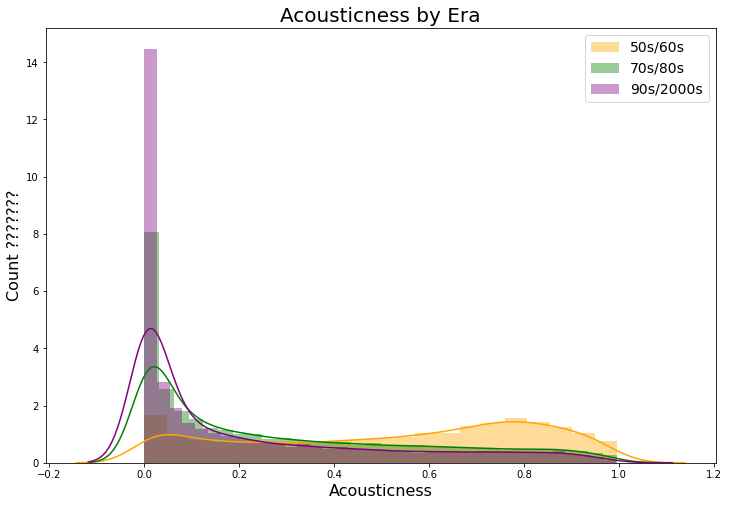

In [24]:
plt.figure(figsize=(12, 8));
ax = sns.distplot(rock_df.acousticness[rock_df['era'] == '50s/60s'], label='50s/60s', color='orange');
ax = sns.distplot(rock_df.acousticness[rock_df['era'] =='70s/80s'], label='70s/80s', color='green');
ax = sns.distplot(rock_df.acousticness[rock_df['era'] == '90s/2000s'], label='90s/2000s', color='purple');
ax.set_title('Acousticness by Era', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('Acousticness', fontsize=16);
ax.legend(prop=dict(size=14));

The chart above shows that a acousticness was generally higher for recent rock songs in the 50s/60s era

# Feature Engineering

In [15]:
X.sample(3)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
59958,0.5840,0.480,210067.0,0.310,0.0,0.066600,5.0,0.1480,-15.364,1.0,36.0,0.0331,121.920,0.370
142221,0.0716,0.657,212987.0,0.857,0.0,0.000015,11.0,0.0774,-7.020,1.0,46.0,0.0456,125.858,0.624
51685,0.6030,0.653,228640.0,0.487,0.0,0.000512,3.0,0.2270,-15.915,0.0,29.0,0.0311,96.360,0.855


### Interaction Features

In [16]:
# Separate categorical and continuous features
cat_features = ['explicit', 'mode']
cont_features = X.drop(cat_features, axis=1).columns
X[cat_features] = X[cat_features].astype(int)

In [17]:
# Interaction Features
interactions = list(combinations(X[cont_features],2))

for combo in interactions:
    X[combo[0]+'_X_'+combo[1]] = X[combo[0]] * X[combo[1]]

### Log Variables

In [18]:
# Log Features
for feat in cont_features:
    X['log_'+feat] = X[feat].map(lambda x: np.log(x))
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

### Squared and Cubed Polynominals

In [19]:
# Polynomials
for feat in cont_features:
    X[feat+'^2'] = X[feat]**2
    X[feat+'^3'] = X[feat]**3

### Dummy Variables

In [20]:
key_dummies = pd.get_dummies(X['key'])
key_dummies.rename(columns = {0: 'key_C', 1: 'key_C#', 2:'key_D', 3:'key_Eb', 4:'key_E', 5:'key_F', 
                              6:'key_Gb', 7: 'key_G', 8:'key_Ab', 9:'key_A', 10:'key_Bb', 11:'key_B'}, inplace=True)
X.drop('key', axis=1, inplace=True)
X = pd.concat([X, key_dummies], axis=1)

# Feature Selection

We decided to drop the popularity feature, because it isn't a song attribute such as loudness/acousticness, and it tends to be biased towards newer music, given that Spotify users tend to be of a younger demographic.

In [21]:
X.drop('popularity', axis=1, inplace=True)

### Standardize

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

## Logistic Regression Feature Selection 
### with all features

In [33]:
logreg = LogisticRegression(C=1e5, class_weight='balanced')
lr_1 = logreg.fit(X_train, y_train)
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6660692167683149
Test F1: 0.6678943028669249 

Train Accuracy: 0.666191381495564
Test Accuracy: 0.6679340937896071 

Train Recall: 0.666191381495564
Test Recall: 0.6679340937896071


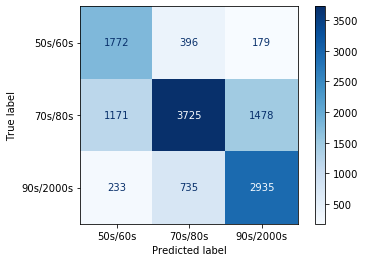

In [24]:
metrics.plot_confusion_matrix(lr_1,X_test,y_test,cmap=plt.cm.Blues);

### Select K-Best Features
found to make negligible difference, chose 71 bc it provides a high F1 with fewer features

In [30]:
k=71
selector = SelectKBest(k=k)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

# Run logistic regression with 71 best features
logreg_kbest = LogisticRegression(C=1e5, class_weight='balanced')
lr_kbest = logreg_kbest.fit(X_train_kbest, y_train)
y_train_pred = logreg_kbest.predict(X_train_kbest)
y_test_pred = logreg_kbest.predict(X_test_kbest)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6647379488499208
Test F1: 0.6646391863554789 

Train Accuracy: 0.6649767638360794
Test Accuracy: 0.6644486692015209 

Train Recall: 0.6649767638360794
Test Recall: 0.6644486692015209


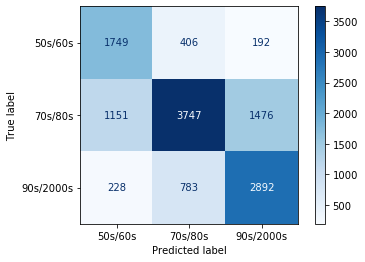

In [26]:
metrics.plot_confusion_matrix(lr_kbest,X_test_kbest,y_test,cmap=plt.cm.Blues);

### Recursive Feature Elimination
Determine best features using RFECV. This feature list is used for other models below as well to pare down the number of features used, although it was created for a logreg model. (Takes a long time to run, so we pickled the RFE feature list)

In [27]:
# logreg = LogisticRegression(C=1e5, class_weight='balanced')
# selector = RFECV(estimator=logreg, step=1, cv=5, scoring='f1_weighted', n_jobs=-1)
# selector.fit(X_train, y_train)
# X_train_rfe = selector.transform(X_train)
# X_test_rfe = selector.transform(X_test)

# rfe_features = X.columns[selector.support_]
# pickle_out = open("pickled/rfe_features.pickle","wb")
# pickle.dump(rfe_features, pickle_out)
# pickle_out.close()

### Logistic Regression with RFE Features
Train/Test Split and Scaling with only RFE Features

In [28]:
pickle_in = open("pickled/rfe_features.pickle","rb")
rfe_features = pickle.load(pickle_in)
pickle_in.close()
rfe_features = rfe_features.drop('popularity') # dropped popularity earlier, so need to reflect the change here


X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X[rfe_features], y, test_size=0.25, random_state=5)
scaler = StandardScaler() 
X_train_rfe = scaler.fit_transform(X_train_rfe)
X_test_rfe = scaler.transform(X_test_rfe)  

In [31]:
# Fit the model/make predictions
logreg_rfe = LogisticRegression(C=1e5, class_weight='balanced')
lr_rfe = logreg_rfe.fit(X_train_rfe, y_train)
y_train_pred = logreg_rfe.predict(X_train_rfe)
y_test_pred = logreg_rfe.predict(X_test_rfe)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6632363599017727
Test F1: 0.6626818814949237 

Train Accuracy: 0.6635509083227714
Test Accuracy: 0.6630228136882129 

Train Recall: 0.6635509083227714
Test Recall: 0.6630228136882129


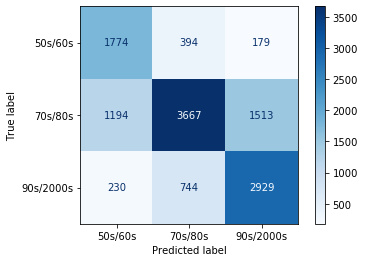

In [35]:
metrics.plot_confusion_matrix(lr_rfe,X_test_rfe,y_test,cmap=plt.cm.Blues)

## KNN Model Feature Selection
Loop to find optimal n value for KNN - determined to be 17

In [36]:
# for n in range(1,21):
#     knn = KNeighborsClassifier(n_neighbors=n)
#     knn.fit(X_train, y_train)
#     y_train_pred = knn.predict(X_train)
#     y_test_pred = knn.predict(X_test)
#     print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
#     print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'), 'for n:', n)

###  KNN with RFE features

In [60]:
# Best KNN Model (n=17)
knn_rfe = KNeighborsClassifier(n_neighbors=17)
knn_model = knn_rfe.fit(X_train_rfe, y_train)
y_train_pred = knn_rfe.predict(X_train_rfe)
y_test_pred = knn_rfe.predict(X_test_rfe)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

KeyboardInterrupt: 

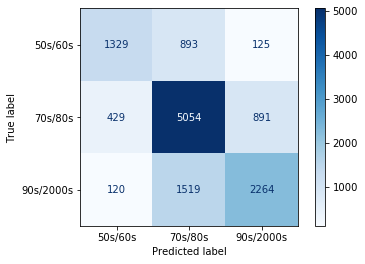

In [38]:
metrics.plot_confusion_matrix(knn_model,X_test_rfe,y_test,cmap=plt.cm.Blues)

## Decision Tree Feature Selection
### With all features

In [39]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6, class_weight='balanced', )
dt = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6539370976409138
Test F1: 0.6464137104904311 

Train Accuracy: 0.654124419095902
Test Accuracy: 0.6465462610899874 

Train Recall: 0.654124419095902
Test Recall: 0.6465462610899874


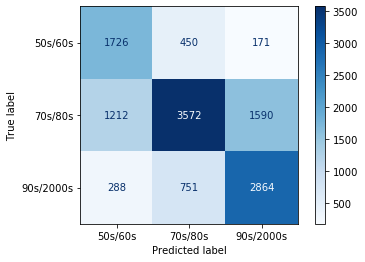

In [40]:
metrics.plot_confusion_matrix(dt,X_test,y_test,cmap=plt.cm.Blues)

In [ ]:
fig = plt.figure(figsize=(35,35))
dt_plot = tree.plot_tree(dtc, 
                   feature_names=X.columns,  
                   filled=True, fontsize=13,precision=0)
plt.savefig('tree_plot',dpi=100)`z

### With only RFE Features

In [44]:
tree_rfe = DecisionTreeClassifier(criterion='gini', max_depth=6, class_weight='balanced', )
dt_rfe = tree_rfe.fit(X_train_rfe,y_train)
y_train_pred = tree_rfe.predict(X_train_rfe)
y_test_pred = tree_rfe.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6590442992073947
Test F1: 0.6534178591551124 

Train Accuracy: 0.6589300802703845
Test Accuracy: 0.6533586818757922 

Train Recall: 0.6589300802703845
Test Recall: 0.6533586818757922


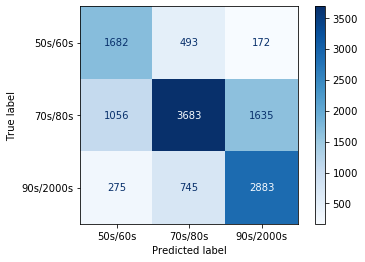

In [43]:
metrics.plot_confusion_matrix(dt_rfe,X_test_rfe,y_test,cmap=plt.cm.Blues)

## Random Forest Feature Selection
### With all features

In [45]:
forest = RandomForestClassifier(random_state = 1, max_leaf_nodes = 40, 
                                criterion = 'entropy',n_estimators=10, 
                                min_samples_leaf = 5, max_depth=7, 
                                max_features= None, n_jobs=-1,
                               class_weight='balanced_subsample')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.651927275951138
Test F1: 0.6503897988392581 

Train Accuracy: 0.6528569919729615
Test Accuracy: 0.6512198986058302 

Train Recall: 0.6528569919729615
Test Recall: 0.6512198986058302


### With only RFE features

In [47]:
forest_rfe = RandomForestClassifier(random_state = 1, max_leaf_nodes = 40, 
                                criterion = 'entropy',n_estimators=10, 
                                min_samples_leaf = 5, max_depth=7, 
                                max_features= None, n_jobs=-1,
                               class_weight='balanced_subsample')
forest_rfe.fit(X_train_rfe, y_train)
y_train_pred = forest_rfe.predict(X_train_rfe)
y_test_pred = forest_rfe.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.6537447781857724
Test F1: 0.6525716435908513 

Train Accuracy: 0.6544412758766371
Test Accuracy: 0.6532002534854245 

Train Recall: 0.6544412758766371
Test Recall: 0.6532002534854245


## XGBoost Feature Selection
### All Features

In [50]:
xg = xgb.XGBClassifier(objective ='multi:softmax', 
                           num_class = 3,
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1,
                           n_estimators = 50)
xg.fit(X_train,y_train)
y_train_pred = xg.predict(X_train)
y_test_pred = xg.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.711432687120167
Test F1: 0.7050734169115912 

Train Accuracy: 0.7146440642163076
Test Accuracy: 0.7086501901140685 

Train Recall: 0.7146440642163076
Test Recall: 0.7086501901140685


### Only RFE Features

In [51]:
xg_rfe = xgb.XGBClassifier(objective ='multi:softmax', 
                           num_class = 3,
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1,
                           n_estimators = 50)
xg_rfe.fit(X_train_rfe,y_train)
y_train_pred = xg_rfe.predict(X_train_rfe)
y_test_pred = xg_rfe.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

Train F1: 0.7096165896730654
Test F1: 0.7014267798929669 

Train Accuracy: 0.7129013519222644
Test Accuracy: 0.7049271229404309 

Train Recall: 0.7129013519222644
Test Recall: 0.7049271229404309


# Hyperparameter Tuning

## KNN Model Tuning

In [1]:
#Determine Hyperparameters
knn_param_grid = {
    'leaf_size' : list(range(1,30)),
    'n_neighbors' : list(range(1,30)),
    'p':[1,2]}

#Instantiate new KNN classifier
knn_tuning = KNeighborsClassifier()

#GridSearch
clf = GridSearchCV(knn_tuning, knn_param_grid, cv=3)

#Fit the model
knn_tuned_model = clf.fit(X_train,y_train)

#List best parameters
print("Best Parameters:")
clf.best_params_

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
#determine parameters to test
clf = DecisionTreeClassifier()
param_grid = {
    'n_estimators' : [100,300,500,800,1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15,20],
    'min_samples_split': [2, 5, 10, 15]}

#call gridsearch model and fit to data
grid_dt = GridSearchCV(clf, param_grid, cv=3)

#Fit the model
grid_dt.fit(X_train,y_train)

#List best parmameters
grid_dt.best_params_

## Random Forest Grid Search

In [ ]:
# Grid Search - RFE features

# params = { 
#     'n_estimators': [10,200,600],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3,  7,  11,  15],
#     'class_weight': ['balanced'],
#     'max_leaf_nodes': [40, 60,  80],
#     'min_samples_leaf': [1, 5,  15,  25,  35]
# }
# grid_forest = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
# grid_forest.fit(X_train_rfe, y_train)

# y_train_pred = grid_forest.predict(X_train_rfe)
# y_test_pred = grid_forest.predict(X_test_rfe)
# print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
# print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

# pickle_out = open("pickled/grid_forest_model.pickle","wb")
# pickle.dump(grid_forest, pickle_out)
# pickle_out.close()

In [57]:
# Make predictions with pickled model
pickle_in = open("pickled/grid_forest_model.pickle","rb")
grid_forest = pickle.load(pickle_in)
pickle_in.close()

y_train_pred = grid_forest.predict(X_train_rfe)
y_test_pred = grid_forest.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6731366104230371
Test F1: 0.6618084183602619


## XGBoost Grid Search

In [ ]:
# XGBoost Grid Search

# xg = xgb.XGBClassifier(objective ='multi:softmax', num_class = 3)
# params = {'n_estimators': [100,500],
#               'learning_rate': [0.1,0.03],
#               'max_depth': [3,  6, 9],
#               'colsample_bytree': [0.5,  1],
#               'min_child_weight': [ 1]
#              }
# grid_xg = GridSearchCV(
#     estimator = xg,
#     param_grid = params, 
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2, 
#     cv=3)
# grid_xg.fit(X_train, y_train)

# Pickle the model
# pickle_out = open("pickled/xgboost_model.pickle","wb")
# pickle.dump(grid_xg, pickle_out)
# pickle_out.close()

In [53]:
# Make preditions with pickled grid xgboost model
pickle_in = open("pickled/xgboost_model.pickle","rb")
grid_xg = pickle.load(pickle_in)
pickle_in.close()

y_train_pred = grid_xg.predict(X_train)
y_test_pred = grid_xg.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))
grid_xg.best_params_

Train F1: 0.9351811775549661
Test F1: 0.7213973804686716


{'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 500}

# Model Evaluation

## Best Logistic Regression (All Features)

In [34]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred))

Train F1: 0.6660692167683149
Test F1: 0.6678943028669249 

Train Accuracy: 0.666191381495564
Test Accuracy: 0.6679340937896071


## Best KNN Model (N=17, RFE Features)

In [61]:
knn_rfe = KNeighborsClassifier(n_neighbors=17)
knn_model = knn_rfe.fit(X_train_rfe, y_train)
y_train_pred = knn_rfe.predict(X_train_rfe)
y_test_pred = knn_rfe.predict(X_test_rfe)

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

Train F1: 0.7150441258210658
Test F1: 0.6806178724941648 

Train Accuracy: 0.7185255597803126
Test Accuracy: 0.6849651457541192 



## Best Decision Tree (RFE Features)

In [59]:
tree_rfe = DecisionTreeClassifier(criterion='gini', max_depth=6, class_weight='balanced', )
dt_rfe = tree_rfe.fit(X_train_rfe,y_train)
y_train_pred = tree_rfe.predict(X_train_rfe)
y_test_pred = tree_rfe.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

Train F1: 0.6590442992073947
Test F1: 0.6534178591551124 

Train Accuracy: 0.6589300802703845
Test Accuracy: 0.6533586818757922 



## Best Random Forest (Grid Search, RFE Features)

In [55]:
pickle_in = open("pickled/grid_forest_model.pickle","rb")
grid_forest = pickle.load(pickle_in)
pickle_in.close()

y_train_pred = grid_forest.predict(X_train_rfe)
y_test_pred = grid_forest.predict(X_test_rfe)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.6731366104230371
Test F1: 0.6618084183602619


## Best XGBoost (Grid Search, All Features)

In [56]:
pickle_in = open("pickled/xgboost_model.pickle","rb")
grid_xg = pickle.load(pickle_in)
pickle_in.close()

y_train_pred = grid_xg.predict(X_train)
y_test_pred = grid_xg.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.9351811775549661
Test F1: 0.7213973804686716


## Voting Classifier (Best Logistic Regression, KNN, and XGBoost Models)

In [83]:
# voter = VotingClassifier(
#                 estimators=[('Logistic', logreg), ('KNN_rfe', knn_model), ('Grid_XGBoost', grid_xg)], 
#                 voting='soft')
# voter.fit(X_train, y_train) 

# Pickle the model
# pickle_out = open("pickled/voter_model.pickle","wb")
# pickle.dump(voter, pickle_out)
# pickle_out.close()

In [82]:
# Retrieve model, make predictions (takes 10 mins)
pickle_in = open("pickled/voter_model.pickle","rb")
voter = pickle.load(pickle_in)
pickle_in.close()

y_train_pred = voter.predict(X_train)
y_test_pred = voter.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted' ))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train F1: 0.8223290707798127
Test F1: 0.7150127758995883


# Feature Importance

### Logistic Regression Feature Importance

In [118]:
# Most important features for 50s/60s Era
sorted(zip(map(lambda x: round(x, 4), logreg.coef_[0]), X.columns), reverse=True)[:10]

[(1.2239, 'popularity^2'),
 (0.6937, 'duration_ms^2'),
 (0.5411, 'log_acousticness'),
 (0.4945, 'acousticness_X_energy'),
 (0.3967, 'popularity_X_valence'),
 (0.363, 'log_speechiness'),
 (0.351, 'log_valence'),
 (0.3507, 'energy_X_popularity'),
 (0.3269, 'danceability_X_instrumentalness'),
 (0.3098, 'loudness_X_valence')]

In [121]:
# Most important features for 70s/80s Era
sorted(zip(map(lambda x: round(x, 4), logreg.coef_[1]), X.columns), reverse=True)[:10]

[(0.8935, 'popularity^3'),
 (0.7343, 'instrumentalness'),
 (0.5762, 'acousticness'),
 (0.5673, 'speechiness'),
 (0.5376, 'energy^3'),
 (0.449, 'danceability_X_duration_ms'),
 (0.4061, 'liveness'),
 (0.3675, 'duration_ms_X_energy'),
 (0.3446, 'instrumentalness_X_loudness'),
 (0.3133, 'loudness^2')]

In [122]:
# Most important features for 90s/2000s Era
sorted(zip(map(lambda x: round(x, 4), logreg.coef_[2]), X.columns), reverse=True)[:10]

[(3.7376, 'log_popularity'),
 (1.0494, 'loudness_X_popularity'),
 (0.5225, 'duration_ms'),
 (0.3841, 'tempo^3'),
 (0.3639, 'danceability_X_duration_ms'),
 (0.3542, 'energy_X_valence'),
 (0.3392, 'loudness^2'),
 (0.331, 'instrumentalness^2'),
 (0.3, 'danceability_X_tempo'),
 (0.2319, 'tempo^2')]

### Random Forest Feature Importance

In [108]:
sorted(zip(map(lambda x: round(x, 4), grid_forest.best_estimator_.feature_importances_), 
           rfe_features), reverse=True)[:10]
       

[(0.1315, 'popularity^3'),
 (0.1139, 'popularity^2'),
 (0.1079, 'log_popularity'),
 (0.1036, 'duration_ms_X_popularity'),
 (0.0492, 'duration_ms'),
 (0.0488, 'log_duration_ms'),
 (0.0486, 'duration_ms^2'),
 (0.0479, 'energy_X_popularity'),
 (0.0305, 'duration_ms_X_energy'),
 (0.0287, 'loudness_X_valence')]

### KNN Feature Importance

KNN feature importance cannot be calculated.

### XGBoost Feature Importance

In [129]:
sorted(zip(map(lambda x: round(x, 4), grid_xg.best_estimator_.feature_importances_), 
           X.columns), reverse=True)[:10]

[(0.0865, 'log_popularity'),
 (0.0664, 'popularity^3'),
 (0.064, 'popularity^2'),
 (0.0334, 'duration_ms_X_popularity'),
 (0.023, 'duration_ms^2'),
 (0.0181, 'loudness^3'),
 (0.0166, 'log_duration_ms'),
 (0.0155, 'duration_ms'),
 (0.0149, 'duration_ms^3'),
 (0.0143, 'loudness')]

# Conclusion

For this project, we were focused on model interpretability to determine which song attributes can help classify songs into specific music eras. 

Our initial predictions were that our models would be inaccurate due to the nature of music, however, our models were able to achieve an F1 score of > .70. 

As our initial EDA had shown, after calculating feature importance, the most significant features used across all models were **popularity, duration, loudness, and acousticness.** 